## Titanic: Machine Learning from Disaster
This is a kaggle competition where we will predict the survival of a subset of titanic passenters (test set), given a set of passengers with known survival (train set). For each passenger there exist several features, including Name, Age, Sex, Ticket number, Ticket class, etc. We follow these steps:

1. Exploring the data
2. Cleanig and feature selection
3. Prediction models, cross-validation and prediction

This kernel led to a kaggle submission accuracy of __0.82296__ and top **4%**. 

If you have already made submissions and want to improve your score, the key points are summarized below:

- Even though the cabin feature has many missing data, it can be replaced by 0, 1. 0 when cabin is NaN and 1 otherwise. We will see that there is a correlation between CabinCode (0 or 1) and survival. 
- Ticket column is usefull; there is a correlation between survival chance and prefix of the Ticket feature. 
- One key to get an score above 0.80 seems to be proper use of Ticket or Family clustering. I grouped passengers based on their ticket numbers (there are multiple individuals with the same ticket numbers!)

### Import the libraries
As the first step all neccessary libraries will be imported; this list will be updated as we are going forward

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble, model_selection
import seaborn as sns
import numpy as np
from collections import Counter

## 1. Import and explore the data
We import and explore the data; how many samples do we have, what are the attributes are, what are the missing data... 

In [2]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Explore the data
We use describe() method to quickly get an overview of the features and the output ('Survived'). 

In [3]:
trData.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From the training data (trData), the average survival data is ~0.384, so only 342 passengers out of 891 (see below) passengers survived. 

In [4]:
trData['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

# 2. Cleaning and feature engineering
After exploring the data, we start cleaning the data and at the same time do feature engineering by looking at the correlation of the features (including the new features that we may create) with survival. 

## 2.1 Filling the missing data

In [5]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
**********************************************************************
Total number of samples in test set is: 418
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


There are two missing data for the 'Embarked' feature. We fill in these values with the mode() (i.e., most frequent value)

In [6]:
for data in data_list:
    data['Embarked'].fillna(trData['Embarked'].mode()[0], inplace = True)

In [7]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

Next we fill in the data for 'Fare'; we fill in this data as a function of the Pclass as there is a strong corelation between 'Fare' and 'Pclass':

In [8]:
PclassVsFare = combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).mean()
PclassVsFare

,Pclass,Fare
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [9]:
# The Pclass of the sample with missing 'Fare' value
testData['Pclass'][testData['Fare'].isnull()] 

152    3
Name: Pclass, dtype: int64

In [10]:
# The passenger with missing class has a Pclass of 3 whose average Fare is 13.67 
testData['Fare'].fillna(PclassVsFare.loc[2,'Fare'], inplace = True);

Next we fill in the Age missing data. However, we first look at the Title column as there might be a strong corelation between the Title and Age. If yes, then we can replace the Age missing value as a function of the Title. 

In [11]:
for data in data_list:
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [12]:
testData['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: Title, dtype: int64

In [13]:
trData['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Don               1
Capt              1
Ms                1
Sir               1
Lady              1
the Countess      1
Mme               1
Jonkheer          1
Name: Title, dtype: int64

We reassign the title values as follows:

In [14]:
for data in data_list:
    data['Title'] = data['Title'].replace(['Lady', 'Sir', 'the Countess'], 'Royal')
    data['Title'] = data['Title'].replace(['Ms', 'Mlle'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Title'] = data['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')

In [15]:
trData['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       20
Royal       3
Name: Title, dtype: int64

In [16]:
testData['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: Title, dtype: int64

We see below that there is a strong corelation between 'Title' and 'Age'; so we replace the Age missing data as a function of the 'Title'. 

In [19]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)
title_vs_age = combinedData[['Title', 'Age']].groupby(['Title'], as_index = False).mean()
title_vs_age

,Title,Age
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.400000
5,Royal,43.333333


In [20]:
for i in range(0, len(title_vs_age)):
    title_temp = title_vs_age.loc[i]['Title']
    trData.loc[trData['Age'].isnull() & (trData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]
    testData.loc[testData['Age'].isnull() & (testData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]

Replacing the cabin code with 0, and 1. The missing data is replaced with 0, and if the cabin code exists, it is replace by 1. 

In [21]:
for data in data_list:
    data['CabinCode'] = (data['Cabin'].notnull()) * 1

## 2.2 Define new features

**Nfamily feature**

In [22]:
for data in data_list:
    data['Nfamily'] = data['Parch'] + data['SibSp'] + 1

In [23]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

**Ticket Clustering**

Grouping (clustering) the passengers based on their Ticket numbers. There are many groups of passengers with the same ticket number. We assign a survival rate to each ticket number and use it as a new feature. There is a strong corelation between the ticket survival rate and the passenger survival rate (in other words, if most of the group (with the same ticket number) suvive it is more likely for the passenger to survive). 

In [24]:
combinedData.loc[combinedData['Ticket'] == 'A/5. 851']

,Age,Cabin,CabinCode,Embarked,Fare,Name,Nfamily,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
153,40.500000,NaN,0,S,14.5,"van Billiard, Mr. Austin Blyler",3,2,154,3,male,0,0.0,A/5. 851,Mr
1083,11.500000,NaN,0,S,14.5,"van Billiard, Master. Walter John",3,1,1084,3,male,1,NaN,A/5. 851,Master
1235,5.482642,NaN,0,S,14.5,"van Billiard, Master. James William",3,1,1236,3,male,1,NaN,A/5. 851,Master


In [25]:
# combinedData['FamilyName'] = combinedData.Name.str.extract('(\w+),', expand = False)
# trData['FamilyName'] = trData.Name.str.extract('(\w+),', expand = False)
# testData['FamilyName'] = testData.Name.str.extract('(\w+),', expand = False)

In [30]:
# combinedData['FamilyName'].value_counts()

In [27]:
ticket_counts = combinedData['Ticket'].value_counts()
ticket_unique = combinedData['Ticket'].value_counts().index

In [28]:
temp_surv_array = []
for i in range(0, len(ticket_unique)):
    expression1 = (((testData['Ticket'] == ticket_unique[i]).sum() > 0) & (((trData['Ticket'] == ticket_unique[i]).sum()) > 1))
    expression2 = (((testData['Ticket'] == ticket_unique[i]).sum() > 0) & (((trData['Ticket'] == ticket_unique[i]).sum()) == 1))
    if expression1:
        if trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean() > 0.75:
            survival_rate_i =  1
        elif 0.5 <= trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean() <=0.75:
            survival_rate_i = 0.5
        elif 0.25 <= trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean() < 0.5:
            survival_rate_i = 0.25
        else:
            survival_rate_i = 0
    elif expression2:
        survival_rate_i =  0.5 * trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean()
    else:
        survival_rate_i = -1
    temp_surv_array.append(survival_rate_i)

In [31]:
myDict = dict(zip(ticket_unique, temp_surv_array))

In [32]:
for data in data_list:
    data['TicketSurvivalRate'] = data['Ticket'].apply(lambda x: myDict[x])
testData['TicketSurvivalRate'].fillna(0, inplace = True);

In [ ]:
# labelName = 'FamilyName'
# family_counts = combinedData[labelName].value_counts()
# family_unique = combinedData[labelName].value_counts().index
# temp_surv_array = []
# for i in range(0, len(family_unique)):
#     expression1 = (((testData[labelName] == family_unique[i]).sum() > 0) & (((trData[labelName] == family_unique[i]).sum()) > 1))
#     expression2 = (((testData[labelName] == family_unique[i]).sum() > 0) & (((trData[labelName] == family_unique[i]).sum()) == 1))
#     if expression1:
#         if trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean() > 0.75:
#             survival_rate_i =  1
#         elif 0.5 <= trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean() <=0.75:
#             survival_rate_i = 0.5
#         elif 0.25 <= trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean() < 0.5:
#             survival_rate_i = 0.25
#         else:
#             survival_rate_i = 0
#     elif expression2:
#         survival_rate_i =  0.5 * trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean()
#     else:
#         survival_rate_i = -1
#     temp_surv_array.append(survival_rate_i)
# myDict = dict(zip(family_unique, temp_surv_array))
# for data in data_list:
#     data['FamilySurvivalRate'] = data[labelName].apply(lambda x: myDict[x])

In [33]:
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinCode,Nfamily,FamilyName,TicketSurvivalRate
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,2,Braund,-1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,2,Cumings,0.5
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,Heikkinen,-1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,2,Futrelle,-1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,1,Allen,-1.0


As you can see below, there is a strong corelation between 'TicketSurvivalRate' and 'Survived'.

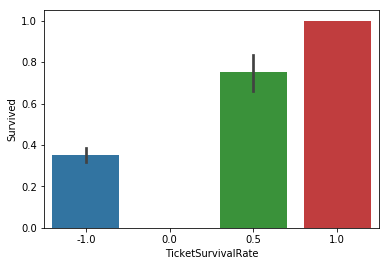

In [34]:
sns.barplot(x = 'TicketSurvivalRate', y = 'Survived', data = trData)
plt.show()

In [35]:
trData['TicketSurvivalRate'].value_counts()

-1.0    684
 0.5     85
 0.0     84
 1.0     38
Name: TicketSurvivalRate, dtype: int64

In [37]:
# sns.barplot(x = 'FamilySurvivalRate', y = 'Survived', data = trData)
# plt.show()

In [38]:
# combinedData.loc[combinedData['FamilyName'] == 'Asplund'][['Name', 'Nfamily', 'Survived','Ticket']]

## 2.3 Convert categorial values to discrete values

In [43]:
trData.dtypes

PassengerId              int64
Survived                 int64
Pclass                   int64
Name                    object
Sex                     object
Age                    float64
SibSp                    int64
Parch                    int64
Ticket                  object
Fare                   float64
Cabin                   object
Embarked                object
Title                   object
CabinCode                int64
Nfamily                  int64
FamilyName              object
TicketSurvivalRate     float64
AgeGroup              category
dtype: object

**age bins**

In [41]:
age_bins = [0, 12, 19, 25, 35, 60, np.inf]
age_labels = ['Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
trData['AgeGroup'] = pd.cut(trData["Age"], age_bins, labels = age_labels)
testData['AgeGroup'] = pd.cut(testData["Age"], age_bins, labels = age_labels)

In [44]:
trData['AgeGroup'].value_counts()

Young Adult    315
Adult          213
Student        173
Teenager        95
Child           73
Senior          22
Name: AgeGroup, dtype: int64

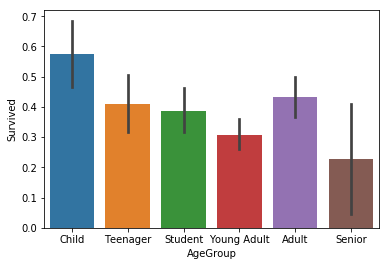

In [45]:
sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData)
plt.show()

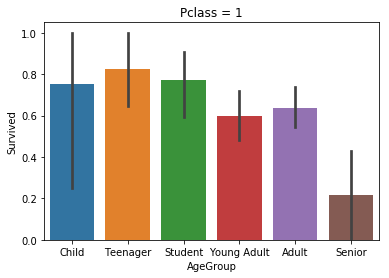

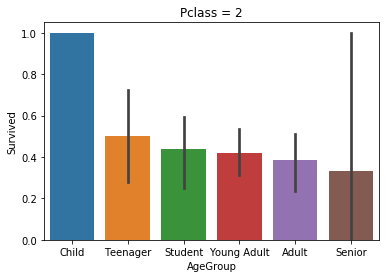

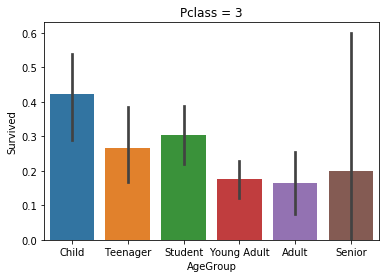

In [46]:
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

**Fare bins**

In [47]:
trData['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [48]:
pd.qcut(trData['Fare'], 3).value_counts()

(-0.001, 8.662]    308
(26.0, 512.329]    295
(8.662, 26.0]      288
Name: Fare, dtype: int64

In [49]:
combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).median()

,Pclass,Fare
0,1,60.0000
1,2,15.0458
2,3,8.0500


In [50]:
trData['Fare'].describe()
fare_bins = [-0.1,  7.5, 15, 40, 70, np.inf]
fare_labels = ['Cheap', 'BelowAverage', 'Average', 'AboveAverage','Expensive']
trData['FareBin'] = pd.cut(trData['Fare'], fare_bins, labels = fare_labels)
testData['FareBin'] = pd.cut(testData['Fare'], fare_bins, labels = fare_labels)

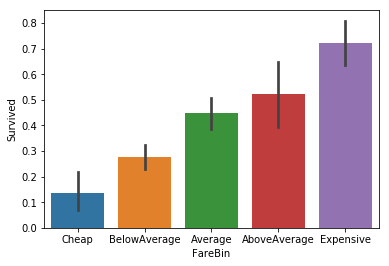

In [51]:
sns.barplot(x = 'FareBin', y = 'Survived', data = trData)
plt.show()

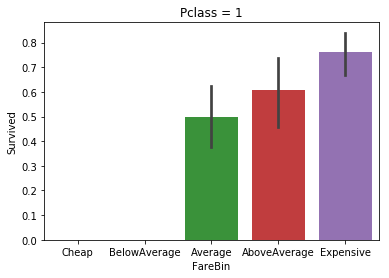

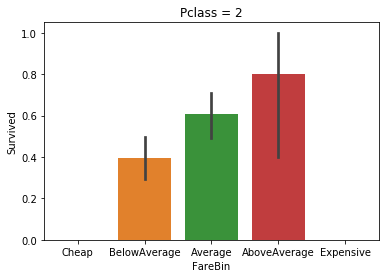

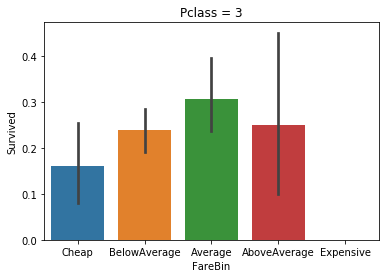

In [52]:
# Check variation of survival rate vs agegroup within the three Pclasses (this helps picking the right age_bins)
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

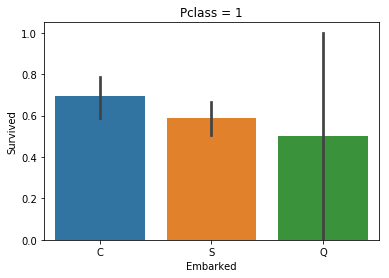

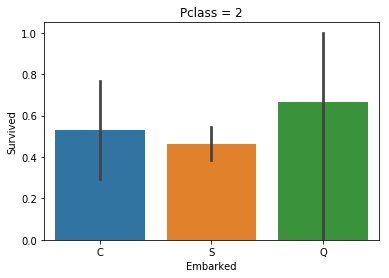

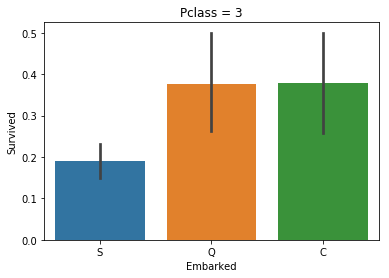

In [53]:
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [54]:
trData['FareBin'].value_counts()

BelowAverage    371
Average         257
Expensive       105
Cheap            87
AboveAverage     71
Name: FareBin, dtype: int64

In [55]:
TicketVec = []
for data in data_list:
    for i in list(data.Ticket):
        if not i.isdigit() :
            TicketVec.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
        else:
            TicketVec.append("X")
    data["TicketLetter"] = TicketVec
    data["TicketLetter"].head()
    TicketVec = []

**Ticket prefix as a new feature**:

In [56]:
trData['TicketLetter'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: TicketLetter, dtype: object

In [57]:
for data in data_list:
    data['TicketPrefix'] = data['TicketLetter'].apply(lambda x: 'Rare' if data['TicketLetter'].value_counts()[x] < 6 else x)

In [58]:
testData['TicketPrefix'].value_counts()

X          296
Rare        40
PC          32
CA          27
SOTONOQ      9
A5           7
SCPARIS      7
Name: TicketPrefix, dtype: int64

In [59]:
trData['TicketPrefix'].value_counts()

X          661
PC          60
Rare        45
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
A4           7
SCPARIS      7
SOC          6
STONO2       6
Name: TicketPrefix, dtype: int64

In [61]:
testData['Ticket'].value_counts();

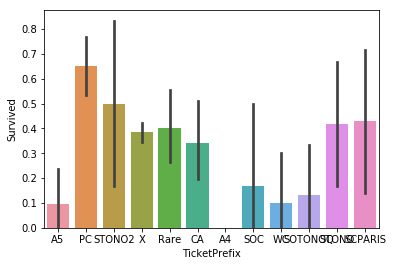

In [62]:
sns.barplot(x = 'TicketPrefix', y = 'Survived', data = trData)
plt.show()

In [63]:
label = LabelEncoder()
for data in data_list:
    #data['FareBinCode'] = label.fit_transform(data['FareBin'])
    #data['AgeBinCode'] = label.fit_transform(data['AgeBin']) 
    #data['TicketCode'] = label.fit_transform(data['TicketPrefix'])
    data['TicketCode'] = data['TicketPrefix'].replace(['X','Rare', 'PC', 'CA', 'A5', 'SOTONOQ', 'STONO', 'WC', 'SCPARIS', 'A4', 'SOC', 'STONO2']
                                                      , [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    data['SexCode'] = data['Sex'].replace(['female', 'male'], [0, 1])
    data['EmbarkedCode'] = data['Embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])
    data['TitleCode'] = data['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master','Royal', 'Rare'], [0, 1, 2, 3, 4, 5])
    data['IsAlone'] = 1
    data.loc[data['Nfamily'] > 1, 'IsAlone'] = 0
    data['AgeGroup'] = data['AgeGroup'].replace(age_labels,[0, 1, 2, 3, 4, 5])
    data['FareBin'] = data['FareBin'].replace(fare_labels, [0, 1, 2, 3, 4])

## 2.3. More feature engineering

In [64]:
trData[['Nfamily', 'Survived']].groupby(['Nfamily'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Nfamily,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [65]:
trData[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [66]:
trData[['Sex','Survived']].groupby(['Sex'], as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [67]:
trData[['SibSp','Survived']].groupby(['SibSp'], as_index = False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [68]:
trData['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [69]:
trData[['Pclass','Fare','Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Fare,Survived
0,1,84.154687,0.629630
1,2,20.662183,0.472826
2,3,13.675550,0.242363


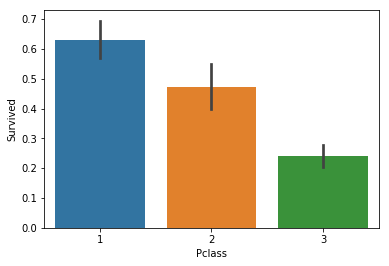

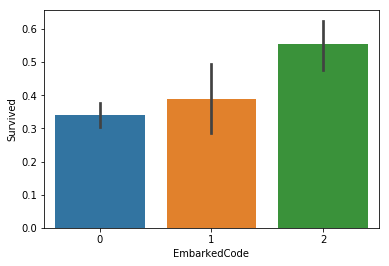

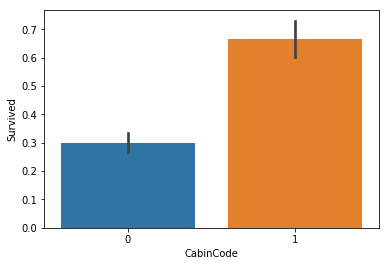

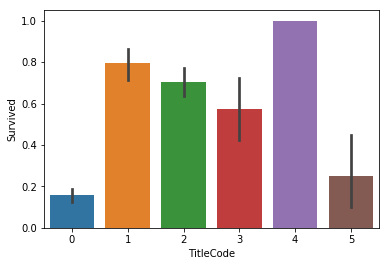

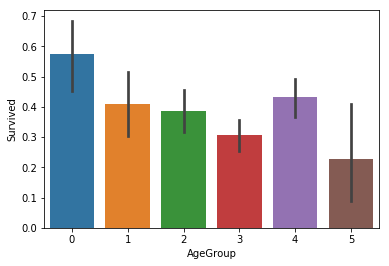

In [70]:
sns.barplot(x="Pclass", y="Survived", data=trData)
plt.show()
sns.barplot(x="EmbarkedCode", y="Survived", data=trData)
plt.show()
sns.barplot(x = "CabinCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "TitleCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "AgeGroup", y = "Survived", data = trData)
plt.show()

In [71]:
pd.crosstab(trData['Sex'], trData['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [72]:
trData[['TitleCode','Survived']].groupby(['TitleCode'], as_index = False).mean()

,TitleCode,Survived
0,0,0.156673
1,1,0.793651
2,2,0.702703
3,3,0.575000
4,4,1.000000
5,5,0.250000


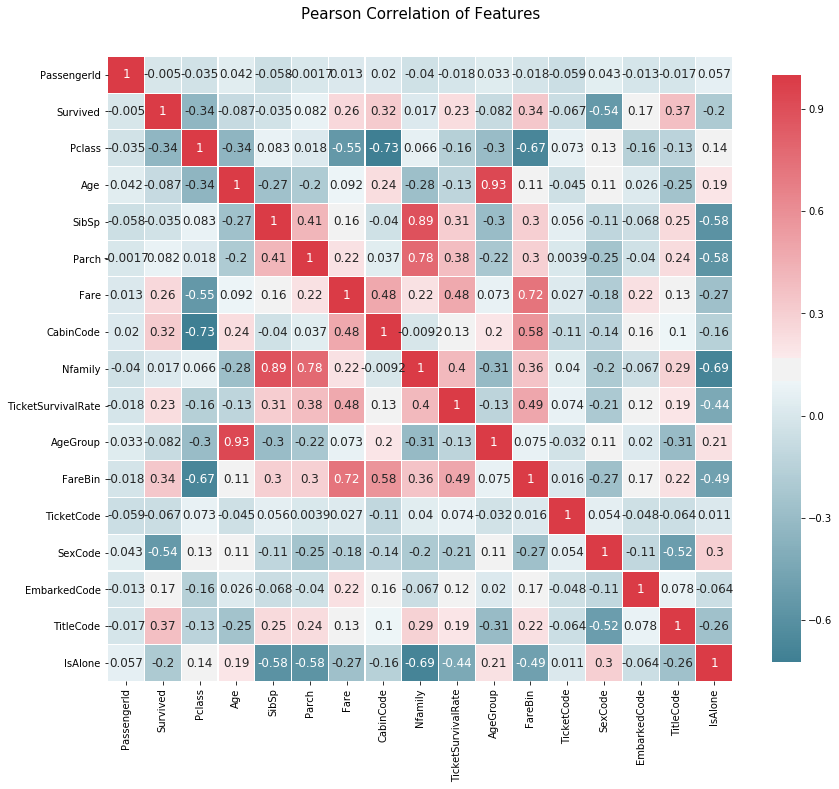

In [73]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData)
plt.show()

# 3. Classification models, cross-validation, and parameter tuning

We will select the independent features with highest corelation with the survival. 

In [74]:
selectedFeatures = ['Pclass', 'SexCode', 'AgeGroup', 'TitleCode', 'Nfamily', 'IsAlone', 'EmbarkedCode', 'FareBin'
                    ,'CabinCode', 'TicketCode', 'TicketSurvivalRate']; # IsAlone is a redundant feature and I think it should be removed, however, with that I got a better submission accuracy on Kaggle
X = trData[selectedFeatures]
y = trData['Survived']

In [75]:
X.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode,TicketSurvivalRate
0,3,1,2,0,2,0,0,0,0,4,-1.0
1,1,0,4,1,2,0,2,4,1,2,0.5
2,3,0,3,2,1,1,0,1,0,11,-1.0
3,1,0,3,1,2,0,0,3,1,0,-1.0
4,3,1,3,0,1,1,0,1,0,0,-1.0


## Cross-validation
First a cross validation; we split the training set (trData) to a test size of 20 percent and train size of 0.8. We do a cross validation on 0.8 set. 

In [76]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=1)

## From the above results we try a voting 
### Comparing different possible voting lists
We try different voting lists, and pick the one with the highest accuracy. Once we decide about the best voting list, we run the gridsearchCV this time for the whole data set

In [77]:
# voting_list = [('grBoost', clf_list[2]), ('randforest', clf_list[3]), ('extree', clf_list[4]), ('knn', clf_list[5])]
# # voting_list = [('randforest', clf_list[3]), ('extree', clf_list[4]), ('grBoost', clf_list[2])]
# voting_list = [('a', clf_list[2]), ('c', clf_list[3]), ('d', clf_list[3])]
# votingC = ensemble.VotingClassifier(estimators=voting_list, voting='soft', n_jobs=4)
# votingC = votingC.fit(Xtrain, ytrain)
# arpredict = votingC.predict(Xtest)
# print(metrics.accuracy_score(ytest, arpredict))
# best_voting_list = votingC

The above number is the approximated accuracy that we should when testing the real data. However, of course we should use all the available results for fitting so we replace Xtrain and ytrain with X and y

In [78]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .4, train_size = .6, random_state = 0) 
grid_bool = [True, False]
C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13,20, 30, 40]
grid_ratio_list = [.1, .25, .5, .75, 1.0]
grid_n_neighbors = range(1, 20)
grid_n_estimator = [10, 50, 100, 300]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

clf_list = [LogisticRegression(), SVC(), ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), 
            ensemble.ExtraTreesClassifier(), KNeighborsClassifier()]
grid_param_list = [[{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'C': C_param_range,
            #'solver': ['newton-cg','lbfgs','liblinear']
             }],
             [{
            'C': C_param_range,
             'gamma': grid_ratio_list
             }],
             [{
              'max_depth': grid_max_depth   
             }], 
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
              'n_neighbors': grid_n_neighbors
             }]
             ]
best_scores_list = []
for clf, param in zip (clf_list, grid_param_list):
    best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'roc_auc'
                                              , n_jobs = 4)
    best_search.fit(X, y) # Note X, y NOT Xtrain, ytrain
    best_param = best_search.best_params_
    best_score = best_search.best_score_
    print('The best parameter for {} is {} with a runtime of seconds with a score of {}'.format(clf.__class__.__name__, best_param, best_score))
    clf.set_params(**best_param) 
    best_scores_list.append(best_score)
print("--"*45, "\nMax cross-validation score is:", max(best_scores_list))
print("--"*45, "\nAverage cross-validation score is:", sum(sorted(best_scores_list, reverse=True)[0:3]) / 3)

The best parameter for LogisticRegression is {'C': 30, 'fit_intercept': True} with a runtime of seconds with a score of 0.8631937591403341
The best parameter for SVC is {'C': 10, 'gamma': 0.1} with a runtime of seconds with a score of 0.8627437888965359
The best parameter for GradientBoostingClassifier is {'max_depth': 2} with a runtime of seconds with a score of 0.9021713391939795
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'random_state': 0, 'n_estimators': 300, 'max_depth': 8} with a runtime of seconds with a score of 0.8997147793624913
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'random_state': 0, 'n_estimators': 300, 'max_depth': 8} with a runtime of seconds with a score of 0.8907523300028961
The best parameter for KNeighborsClassifier is {'n_neighbors': 7} with a runtime of seconds with a score of 0.8498135884717581
------------------------------------------------------------------------------------------ 
Max cross-valida

In [79]:
best_voting_list = [('a', clf_list[2]), ('c', clf_list[3]), ('d', clf_list[4])]
# best_voting_list = [('a', clf_list[2])]
votingC = ensemble.VotingClassifier(estimators=best_voting_list, voting='soft', n_jobs=4)
votingC = votingC.fit(X, y) # Note we fit the Whole X, y
arpredict = votingC.predict(Xtest)
print(metrics.accuracy_score(ytest, arpredict))

0.8659217877094972


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [80]:
testDataTemp = testData[selectedFeatures]
arPredict = votingC.predict(testDataTemp)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [81]:
testDataTemp.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode,TicketSurvivalRate
0,3,1,3,0,1,1,1,1,0,0,-1.0
1,3,0,4,1,2,0,0,0,0,0,-1.0
2,2,1,5,0,1,1,1,1,0,0,-1.0
3,3,1,3,0,1,1,0,1,0,0,-1.0
4,3,0,2,1,3,0,0,1,0,0,0.5


In [82]:
yPredict = pd.DataFrame({'PassengerId':testData['PassengerId'], 'Survived': arPredict})
yPredict.to_csv('../predictions.csv', index = False)

In [83]:
X.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode,TicketSurvivalRate
0,3,1,2,0,2,0,0,0,0,4,-1.0
1,1,0,4,1,2,0,2,4,1,2,0.5
2,3,0,3,2,1,1,0,1,0,11,-1.0
3,1,0,3,1,2,0,0,3,1,0,-1.0
4,3,1,3,0,1,1,0,1,0,0,-1.0


In [84]:
testDataTemp.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode,TicketSurvivalRate
0,3,1,3,0,1,1,1,1,0,0,-1.0
1,3,0,4,1,2,0,0,0,0,0,-1.0
2,2,1,5,0,1,1,1,1,0,0,-1.0
3,3,1,3,0,1,1,0,1,0,0,-1.0
4,3,0,2,1,3,0,0,1,0,0,0.5


In [88]:
now = pd.read_csv('../predictions.csv')
best = pd.read_csv('../predictions_score82296.csv')
print(len(testData.loc[now['Survived'] != best['Survived']]))
testData.loc[now['Survived'] != best['Survived'], ['Ticket', 'Nfamily', 'TicketSurvivalRate']]

0


,Ticket,Nfamily,TicketSurvivalRate


In [90]:
yPredict.loc[now['Survived'] != best['Survived']]

,PassengerId,Survived
